# APSC-5984 Lab 10: Principal Component Analysis (PCA)

## Principal Component Analysis (PCA)

In supervised learning, we may run into a scenario where there are too many features (independent variables) avaialble, which can be problematic when some of the features are highly correlated with each other; this can lead to overfitting and poor generalization on the new data. Dimensionality reduction is a technique to reduce the number of features but still retain the essential information from the original dataset. Principal Component Analysis (PCA) is one of the most popular dimensionality reduction techniques. In this lab, we will learn the intuition behind PCA and how to implement it in Python.

In [13]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

### Toy example: two-dimensional data

Let's start with a simple example of two-dimensional data. We want to build a regression model to predict the sweetness of an orange based on its diameter and weight. We know that the diameter is in a range of 2 to 5 inches, and the weight ($X_w$) has an approximately linear relationship with the diameter ($X_r$)

$$

X_{w} = 4 + 2 X_{r} + \epsilon

$$

And the sweetness ($y$) is a function of the diameter and weight:

$$

y = 1.6 + 5X_{r} - 0.3 X_{w} + \epsilon

$$

where $\epsilon$ is a random noise sampled from a normal distribution. We will simulate data points with the same linear assumption.

     diameter     weight  sweetness
0    2.403660  12.974166  15.082106
1    3.449949  11.581707  13.568140
2    4.870111  12.978510  20.489113
3    4.096204  10.237556  20.320160
4    4.454509  13.406055  13.665637
..        ...        ...        ...
495  3.548378  10.593983  22.074615
496  2.258841  10.905601  14.577411
497  4.514855  11.698438  23.235496
498  4.245100  11.263126  16.184893
499  3.953557  12.892222  12.001812

[500 rows x 3 columns]


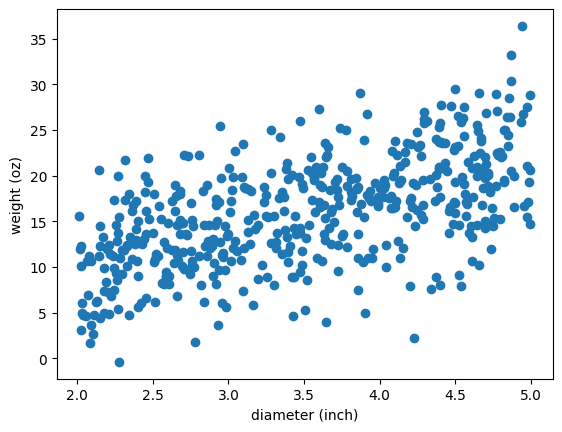

In [14]:
# randomly sample length and width
N = 500
diam = np.random.rand(N) * 3 + 2 # N random numbers between 2 and 5
weight = 4 + 2 * diam + np.random.normal(0, 2, N)
sweet = 1.6 + 5 * diam - 0.3 * weight + np.random.normal(0, 5, N)

# generate a dataframe
df = pd.DataFrame({"diameter": diam, "weight": weight, "sweetness": sweet})
print(df)

# plot
plt.scatter(df["diameter"], df["sweetness"])
plt.xlabel("diameter (inch)")
plt.ylabel("weight (oz)")
plt.show()

You should visually notice that the two features (i.e., diameter and weight) are highly correlated with each other. So the question is, do we really need both the features when either of them can represent one another? Or even better, can we combine the two features into one single feature that can represent both of them?

Here we can formulate the hypotheses into three different models:

$$

\begin{align}


y &= \beta_0 + \beta_1 X_{r} + \beta_2 X_{w} + \epsilon\\

y &= \beta_0 + \beta_1 X_{w} + \epsilon\\

y &= \beta_0 + \beta_1 X_{pc} + \epsilon\\

\end{align}

$$

where $X_{pc}$ is the principal component of the two features.

The first model is the full model with both diameter and weight as features; the second model is the reduced model with only diameter as a feature; and the third model is the reduced model with only principal component as a feature.

#### Data splitting

To examine the performance of the three models, we will split the data into training and testing sets. We will use the training set to fit the three models and use the testing set to evaluate the performance of the three models.

In [15]:
# define X and y
y = df["sweetness"]
X = df[["diameter", "weight"]]
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
display(X_train)
display(y_train)
display(X_test)
display(y_test)

,diameter,weight
30,2.831998,9.331441
115,2.423271,8.739411
66,3.568214,11.904316
146,4.649831,12.329813
176,4.497776,11.720387
...,...,...
298,4.522262,11.927880
404,4.641724,13.879896
158,3.999726,13.939953
486,2.780215,9.838635


30     18.261201
115     6.069266
66     19.783951
146    24.918412
176    15.872391
         ...    
298    14.611235
404    25.537403
158    18.682702
486     1.796961
392    18.612278
Name: sweetness, Length: 400, dtype: float64

,diameter,weight
260,3.234983,11.496000
98,4.695567,12.596503
470,3.338796,10.680261
27,3.786839,9.461439
481,2.305757,7.475095
...,...,...
347,4.295784,13.126683
488,4.536999,14.123976
263,4.988220,15.833963
338,3.856368,14.995389


260    17.152962
98     19.681893
470    24.263229
27     12.141686
481    11.899252
         ...    
347    26.919899
488     7.952279
263    19.250729
338     7.450517
52     14.539885
Name: sweetness, Length: 100, dtype: float64

#### Evalute the performance of the three models

In [17]:
def eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    n = len(y_test)
    k = X_test.shape[1]
    bic = n * np.log(mse) + k * np.log(n)
    print("MSE: {:.4f}".format(mse))
    print("BIC: {:.4f}".format(bic))

#### Model 1: full model

In [18]:
model1 = LinearRegression().fit(X_train, y_train)
y_pred = model1.predict(X_test)
eval(model1, X_test, y_test)

MSE: 23.8029
BIC: 326.1911


#### Model 2: reduced model with only weight as a feature

In [19]:
model2 = LinearRegression().fit(X_train[["weight"]], y_train)
y_pred = model2.predict(X_test[["weight"]])
eval(model2, X_test[["weight"]], y_test)

MSE: 28.4977
BIC: 339.5877


#### Model 3: reduced model with only principal component as a feature

In [20]:
# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create a PCA instance
pca = PCA(n_components=1)
pca.fit(X_train_scaled)

# transform the data
pc_train = pca.transform(X_train_scaled)
pc_test = pca.transform(X_test_scaled)

# fit model
model3 = LinearRegression().fit(pc_train, y_train)
y_pred = model3.predict(pc_test)
eval(model3, pc_test, y_test)


MSE: 24.2768
BIC: 323.5573


### Intuition

The intuition behind PCA is to find a "direction" of the data that has the largest variance. The direction of the data with the largest variance is called the first principal component (PC1). The second principal component (PC2) is the direction of the data that has the largest variance when the data is projected onto the PC1. They are therefore orthogonal (indepedent) to each other. To find the PCs, we need to conduct an eigen decomposition on the covariance matrix of the feature matrix $X$.

### Step 1: find the covariance matrix

The covariance matrix is a square matrix with the same number of rows and columns as the number of features. The element in the $i$ th row and $j$ th column is the covariance between the $i$ th feature and the $j$ th feature. The covariance between two features is defined as:

$$

\sigma_{ij} = \frac{1}{n-1} \sum_{k=1}^{n} (x_{ik} - \bar{x}_i)(x_{jk} - \bar{x}_j)

$$

where $n$ is the number of data points, $\bar{x}_i$ is the mean of the $i$ th feature, and $x_{ik}$ is the $k$ th data point of the $i$ th feature.

In linear algebra form, it can be written a simpler form if we scale the data by subtracting the mean and dividing by the standard deviation:

$$

\Sigma = \frac{1}{n - 1} X^T X

$$

where $X$ is the feature matrix with $n$ rows and $p$ columns.



In [21]:
# scale
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# covariance matrix (numpy)
cov_np = np.cov(X_scaled.T)
# covariance matrix (manual)
n = X_scaled.shape[0]
cov_manual = np.dot(X_scaled.T, X_scaled) / (n - 1)

# compare
print("Numpy covariance matrix:")
display(cov_np)
print("Manual covariance matrix:")
display(cov_manual)


Numpy covariance matrix:


array([[1.00200401, 0.66581281],
       [0.66581281, 1.00200401]])

Manual covariance matrix:


array([[1.00200401, 0.66581281],
       [0.66581281, 1.00200401]])

### Step 2: Eigen decomposition

The purpose of eigen decomposition is to find the eigenvectors and eigenvalues of the covariance matrix. The eigenvectors are the directions of the data with the largest variance. The eigenvalues are the variances of the data along the eigenvectors.

An eigen decomposition of a matrix $\Sigma$ is a factorization of the form:

$$

\Sigma = V \Lambda V^{-1}

$$

where $V$ is a matrix whose columns are the eigenvectors of $\Sigma$, and $\Lambda$ is a diagonal matrix whose diagonal elements are the eigenvalues of $\Sigma$.

In Python, we can use the `numpy.linalg.eig` function to perform the eigen decomposition, which returns the eigenvalues and eigenvectors of the covariance matrix.

In [22]:
# eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(cov_np)

# display
print("Eigenvalues:")
display(eigvals)
print("Eigenvectors:")
display(eigvecs)

Eigenvalues:


array([1.66781682, 0.33619119])

Eigenvectors:


array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

### Step 3: Transform the data

If we want to calculate the first principal component, we can simply project the data onto the first eigenvector:

$$

X_{pc1} = X V_1

$$

where $V_1$ is the first eigenvector of the covariance matrix, which is also the first column of the eigenvectors $V$.

To transform the entire dataset, we can simply multiply the feature matrix $X$ by the eigenvectors $V$:

$$

X_{pc} = X V

$$

where $V$ is the matrix of eigenvectors.


In [23]:
PCs = np.dot(X_scaled, eigvecs)
variances = eigvals / np.sum(eigvals)
print("Principal components:")
display(PCs[:5])
print("Variance explained by each PC:")
display(variances)

Principal components:


array([[-0.3938824 ,  1.39558792],
       [ 0.08097384,  0.17416052],
       [ 1.60663378, -0.60259971],
       [ 0.24450509, -0.71004144],
       [ 1.38435373, -0.15108969]])

Variance explained by each PC:


array([0.83224059, 0.16775941])

Or we can use the `sklearn.decomposition.PCA` function to perform the PCA transformation.

In [24]:
# create a PCA instance
pca = PCA(n_components=2)
pca.fit(X_scaled)

# transform the data
PCs = pca.transform(X_scaled)
variances = pca.explained_variance_ratio_
print("Principal components:")
display(PCs[:5])
print("Variance explained by each PC:")
display(variances)

Principal components:


array([[ 0.3938824 , -1.39558792],
       [-0.08097384, -0.17416052],
       [-1.60663378,  0.60259971],
       [-0.24450509,  0.71004144],
       [-1.38435373,  0.15108969]])

Variance explained by each PC:


array([0.83224059, 0.16775941])

### Feature dependency

We want to discuss the effectiveness of PCA when the features are highly correlated with each other. Let's simulate two datasets with different linear dependencies between the features. The first dataset has a strong linear dependency between the features, and the second dataset has a weak linear dependency between the features.

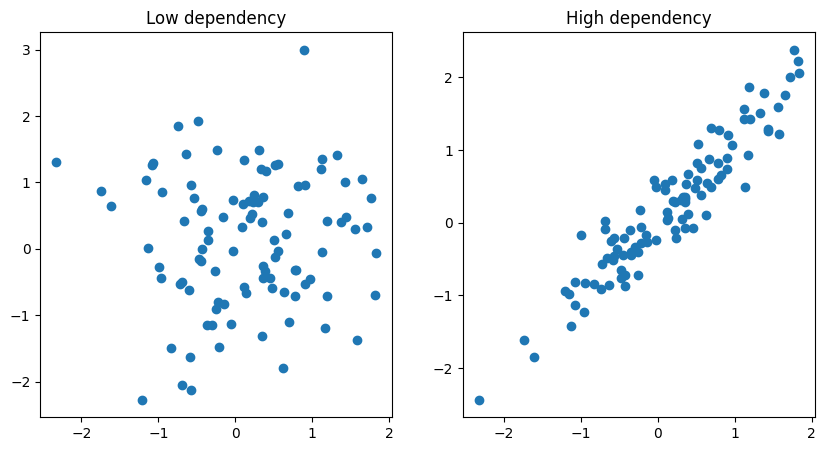

In [25]:
x = np.random.normal(0, 1, 100)
X1 = np.vstack([x, np.random.normal(0, 1, 100)]).T # low dependency
X2 = np.vstack([x, x + np.random.normal(0, .3, 100)]).T # high dependency

# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(X1[:, 0], X1[:, 1])
ax[0].set_title("Low dependency")
ax[1].scatter(X2[:, 0], X2[:, 1])
ax[1].set_title("High dependency")
plt.show()

In [26]:
# X1: low dependency
pca = PCA(n_components=2)
pca.fit(X1)
print("X1: Variance explained by each PC:")
display(pca.explained_variance_ratio_)

# X2: high dependency
pca = PCA(n_components=2)
pca.fit(X2)
print("X2: Variance explained by each PC:")
display(pca.explained_variance_ratio_)

X1: Variance explained by each PC:


array([0.57393067, 0.42606933])

X2: Variance explained by each PC:


array([0.97227375, 0.02772625])

Compare before and after the PCA transformation

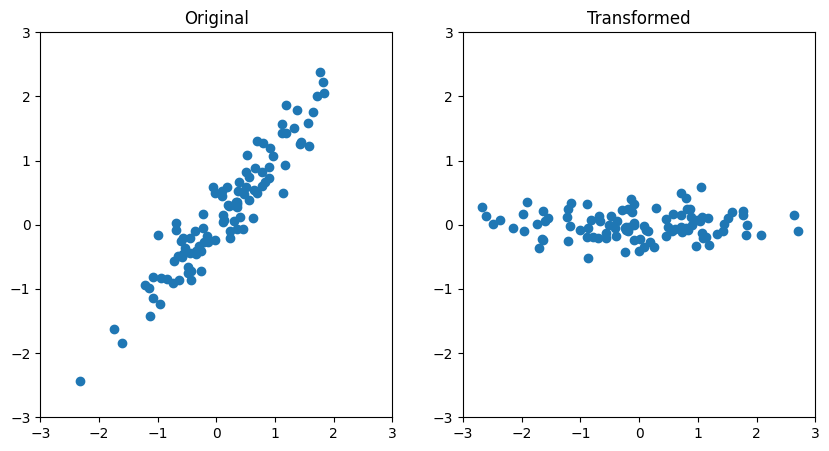

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(X2[:, 0], X2[:, 1])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)
ax[0].set_title("Original")

ax[1].scatter(pca.transform(X2)[:, 0], pca.transform(X2)[:, 1])
ax[1].set_title("Transformed")
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)
plt.show()